# My First Web Scraper!
Peter Crawford

#### Load packages

In [654]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import stats
import statistics
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import requests
from bs4 import BeautifulSoup # package to scrape data
from colorama import Fore, Style

#### Scrape data from Cars.com
This step is where things get a little complicated, you can inspect a webpage in your browser by right clicking and selecting "inspect." If you have had very little exposure to html code (like me), then search for the pattern that aligns with the data you are trying to collect.  

In [2]:
mileage = []
price = []
title = []
extra = []
for i in range(1,44):
    URL = 'https://www.cars.com/for-sale/searchresults.action/?mdId=22265&mkId=20089&page=' + str(i) + '&perPage=100&rd=99999&searchSource=PAGINATION&sort=relevance&stkTypId=28881&zc=84601'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    cars = soup.find_all('div', attrs = {'class':'shop-srp-listings__listing-container'})
    for car in cars:
        mileage.append(car.find('span', class_='listing-row__mileage').text)
        price.append(car.find('span', class_='listing-row__price').text)
        title.append(car.find('h2', class_='listing-row__title').text)
        extra.append(car.find('ul', class_='listing-row__meta').text)

In [30]:
# After figuring out a way to read in multiple pages of data, I no longer use this code
# and have commented it out as it only reads in one page at a time.
# URL = 'https://www.cars.com/for-sale/searchresults.action/?mdId=22265&mkId=20089&page=1&perPage=100&rd=99999&searchSource=PAGINATION&sort=relevance&stkTypId=28881&zc=84601'
# page = requests.get(URL)
# soup = BeautifulSoup(page.content, 'html.parser')
# cars = soup.find_all('div', attrs = {'class':'shop-srp-listings__listing-container'})
# print(cars)

#### Parse through HTML to create python objects

In [41]:
# mileage = []
# price = []                     # this section can get finicky if you don't have it set to "Used"
# title = []
# extra = []
# for car in cars:
#     mileage.append(car.find('span', class_='listing-row__mileage').text)
#     price.append(car.find('span', class_='listing-row__price').text)
#     title.append(car.find('h2', class_='listing-row__title').text)
#     extra.append(car.find('ul', class_='listing-row__meta').text)

In [439]:
list_of_cars = list(zip(mileage, price, title, extra))
df = pd.DataFrame(list_of_cars, columns = ['mileage', 'price', 'title', 'extra'])  

This is our first row of variables:

In [440]:
print(mileage[0].strip(), '\n', 
      price[0].strip(), '\n',
      title[0].strip(), '\n',
      extra[0].split()[0:9])

11,045 mi. 
 $24,495 
 2019 Volkswagen Tiguan 2.0T SE 
 ['Ext.', 'Color:', 'White', 'Int.', 'Color:', 'Gray', 'Transmission:', 'Automatic', 'Drivetrain:']


This next chunk of code to create more variables out of the 'extra' list and clean up the price/mileage strings to be recognized as integers.

In [441]:
year = []
make = []
model = []
type1 = []
type2 = []
extColor = []
intColor = []
transmission = []
drivetrain = []
for col in df.columns:
    if col == "title":
        for a in range(0,len(df)):                     # Parse the "title" column to add more features
            year.append(df[col][a].split()[0])
            make.append(df[col][a].split()[1])
            model.append(df[col][a].split()[2])
            if len(df[col][a].split()) == 4:
                type1.append(df[col][a].split()[3])
            else:
                type1.append('NA')
            if len(df[col][a].split()) == 5:
                type2.append(df[col][a].split()[4])
            else:
                type2.append('NA')
    elif col == "extra":                               # Parse the "extra" column to add more features
        for a in range(0, len(df)):
            extColor.append(df[col][a].split()[2])
            intColor.append(df[col][a].split()[5])
            transmission.append(df[col][a].split()[7])
            drivetrain.append(df[col][a].split()[9])                
    else:                                              # Edit the mileage and price so they can be changed to numeric
        for a in range(0,len(df)):
            df[col][a] = df[col][a].split()[0]
            df[col][a] = df[col][a].replace(",", "")
            df[col][a] = df[col][a].replace("$", "")
            df[col][a] = df[col][a].replace("Not", "0")
            df[col][a] = df[col][a].replace("--", "0")

Add the created variables (from lists) as new columns to the df.

In [442]:
df['year'] = year
df['make'] = make
df['model'] = model
df['type1'] = type1
df['type2'] = type2
df = df.drop(columns = ['title'])
df['extColor'] = extColor
df['intColor'] = intColor
df['transmission'] = transmission
df['drivetrain'] = drivetrain
df = df.drop(columns = ['extra'])

Change mileage, price, and year to be numeric.

In [443]:
df['mileage'] = df['mileage'].astype(float)
df['price'] = df['price'].astype(float)
df['year'] = df['year'].astype(int)

Drop observations in which milieage or price is excluded: (maybe in the future try interpolating)

In [444]:
df = df[df.mileage != 0]
df = df[df.price != 0]

In [445]:
#print('Dropped ' + str(round(100*(4193 - len(df))/4193, 2)) + '% of original data') # 4193 is not accurate depending on when read in 

In [446]:
df = df[df.mileage < 200000]

In [447]:
#df

,mileage,price,year,make,model,type1,type2,extColor,intColor,transmission,drivetrain
0,11045.0,24495.0,2019,Volkswagen,Tiguan,NA,SE,White,Gray,Automatic,AWD
1,45953.0,16400.0,2016,Volkswagen,Tiguan,SEL,NA,White,Beige,Automatic,AWD
2,5764.0,25413.0,2019,Volkswagen,Tiguan,NA,SE,Gray,Black,Automatic,AWD
3,37151.0,21999.0,2018,Volkswagen,Tiguan,NA,NA,Blue,Black,Automatic,FWD
4,77041.0,9995.0,2010,Volkswagen,Tiguan,S,NA,Gold,Gray,Automatic,AWD
...,...,...,...,...,...,...,...,...,...,...,...
4239,28234.0,19399.0,2017,Volkswagen,Tiguan,NA,NA,Blue,Black,Automatic,AWD
4240,25564.0,20318.0,2017,Volkswagen,Tiguan,NA,NA,Black,Beige,Automatic,AWD
4241,101455.0,6584.0,2009,Volkswagen,Tiguan,NA,NA,Black,Other,Automatic,AWD
4242,49168.0,16453.0,2018,Volkswagen,Tiguan,NA,S,Orange,Black,Automatic,FWD


In [448]:
df['type'] = df['type1'] + df['type2']
df = df.drop(columns = ['type1', 'type2'])
df['type'] = df['type'].str.replace('NA','')
df['type'] = df['type'].str.replace("MOTION", "Motion")

In [465]:
df = df.replace({'extColor': {'Red':'Other',
                              'Green':'Other',
                              'Orange':'Other',
                              'Gold':'Other',
                              'Beige':'Other',
                              'Purple':'Other'}})

In [469]:
df = df.replace({'intColor': {'White':'Other',
                              'Orange':'Other',
                              'Gold':'Other',
                              'Brown':'Other'}})

In [478]:
df = df.replace({'transmission': {'Automanual':'Manual',
                                  'Other':'Manual'}})

In [485]:
df = df.replace({'drivetrain': {'4x4/4-wheel':'AWD',
                                '4x2/2-wheel':'FWD',
                                'Unknown':'AWD'}})
# set(list(df['drivetrain'])) # Code to make sure that values were changed

In [496]:
df = df.replace({'type': {'2.0T':'Other',
                          '4-DR':'Other',
                          '4Motion':'Other',
                          '4WD':'Other',
                          'AWD':'Other',
                          'Edition':'Other',
                          'LE':'Other',
                          'Premium':'Other',
                          'R-Line':'Other',
                          'RADIO':'Other',
                          'Sport':'Other',
                          'Wolfsburg':'Other',
                          '':'Other'}})

### Plot data

Text(55.415375652777755, 0.5, 'Price')

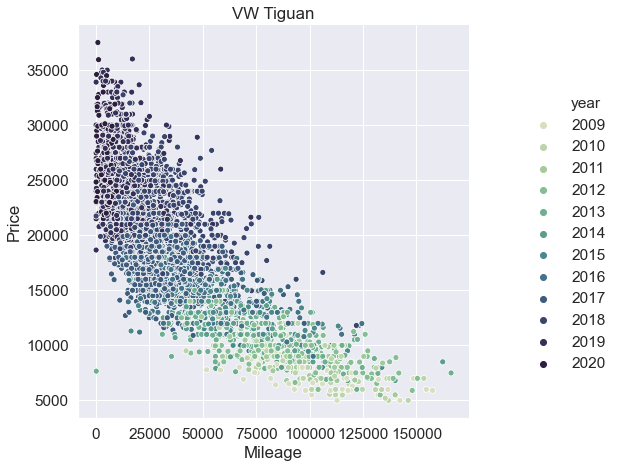

In [333]:
sns.set(font_scale = 1.4)
custPalette = sns.cubehelix_palette(12, start=.5, rot=-.75)
sns.relplot(x="mileage", y="price", hue = "year", data = df, palette = custPalette).fig.set_size_inches(10,7)
plt.title("VW Tiguan")
plt.xlabel("Mileage")
plt.ylabel("Price")

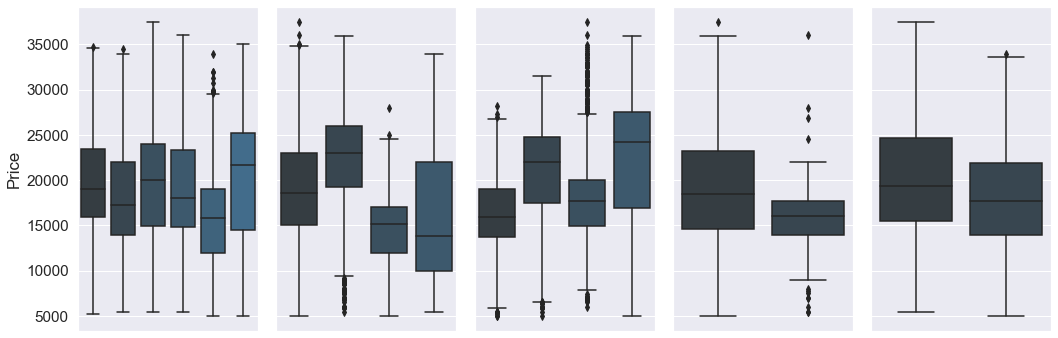

In [538]:
sns.set(font_scale = 1.4)
f, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(15, 5), sharey = True)
sns.set_palette(sns.color_palette("Blues_d", n_colors = 16))

# Interior color
sns.boxplot(x = df['extColor'], y = df['price'], ax = ax1, order = df['extColor'].value_counts().index)
ax1.set(xlabel = None)
ax1.set(xticklabels = [])
ax1.set(ylabel = 'Price')

# Exterior color
sns.boxplot(x = df['intColor'], y = df['price'], ax = ax2, order = df['intColor'].value_counts().index)
ax2.set(xticklabels = [])
ax2.set(xlabel = None)
ax2.set(ylabel = None)

# Type
sns.boxplot(x = df['type'], y = df['price'], ax = ax3, order = df['type'].value_counts().index)
ax3.set(xticklabels = [])
ax3.set(xlabel = None)
ax3.set(ylabel = None)

# Transmission
sns.boxplot(x = df['transmission'], y = df['price'], ax = ax4)
ax4.set(xticklabels = [])
ax4.set(xlabel = None)
ax4.set(ylabel = None)

# Drivetrain
sns.boxplot(x = df['drivetrain'], y = df['price'], ax = ax5)
ax5.set(xticklabels = [])
ax5.set(xlabel = None)
ax5.set(ylabel = None)

plt.tight_layout()
plt.savefig("qual_vars1.png", dpi=300)

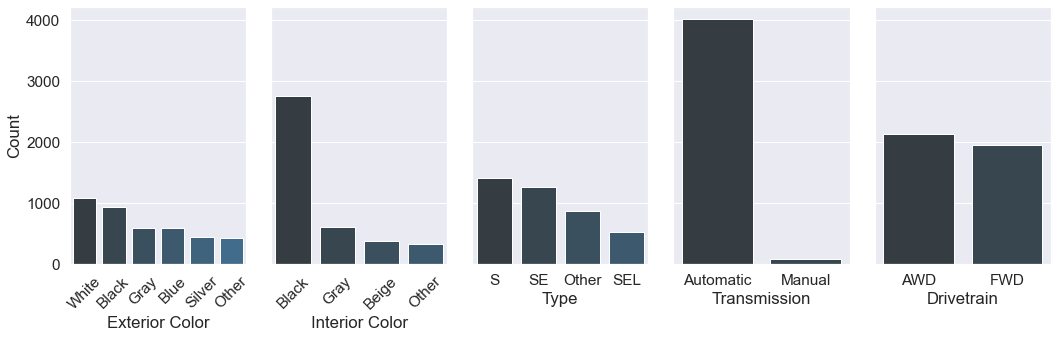

In [539]:
sns.set(font_scale = 1.4)
f, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(15, 5), sharey = True)
sns.set_palette(sns.color_palette("Blues_d", n_colors = 16))

# Interior color
sns.countplot(x = 'extColor', data = df, ax = ax1, order = df['extColor'].value_counts().index)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set(xlabel = 'Exterior Color')
ax1.set(ylabel = 'Count')

# Exterior color
sns.countplot(x = 'intColor', data = df, ax = ax2, order = df['intColor'].value_counts().index)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set(xlabel = 'Interior Color')
ax2.set(ylabel = None)

# Type
sns.countplot(x = 'type', data = df, ax = ax3, order = df['type'].value_counts().index)
ax3.set(xlabel = 'Type')
ax3.set(ylabel = None)

# Transmission
sns.countplot(x = 'transmission', data = df, ax = ax4)
ax4.set(xlabel = 'Transmission')
ax4.set(ylabel = None)

# Drivetrain
sns.countplot(x = 'drivetrain', data = df, ax = ax5)
ax5.set(xlabel = 'Drivetrain')
ax5.set(ylabel = None)

plt.tight_layout()
plt.savefig("qual_vars2.png", dpi=300)

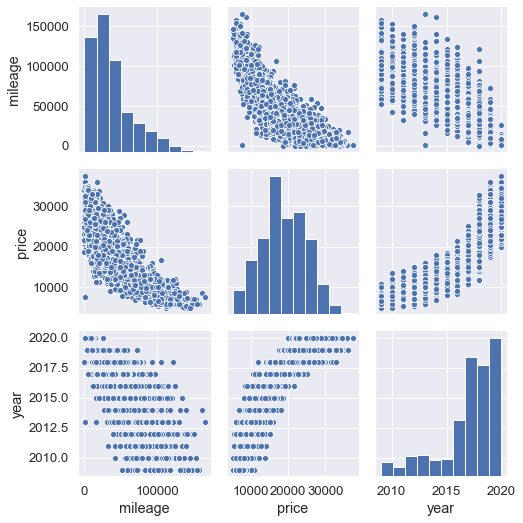

In [540]:
sns.set(font_scale = 1.2)
sns.pairplot(df)#, hue = 'extColor')
plt.tight_layout()
plt.savefig("quant_vars.png", dpi=300)

In [282]:
print('Price average: ', round(np.average(df['price']),3))
print('Mileage average: ', round(np.average(df['mileage']),2))
print('Year average: ', round(np.average(df['year']),2))

Price average:  18736.202
Mileage average:  37763.99
Year average:  2016.86


Would be good to interpolate the excluded values as "other"s:

### Create models:

In [569]:
import statsmodels.formula.api as statsMods
import statsmodels as sm

#### Simple Linear Regression with mileage and price:

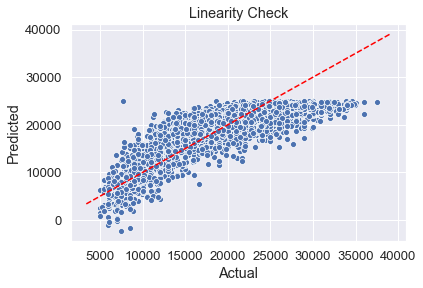

In [556]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = 'red')

ypred = model.predict(df['mileage'].to_numpy().reshape(-1,1)) 
ax = sns.scatterplot(df['price'], ypred)
ax.set(xlabel = 'Actual')
ax.set(ylabel = 'Predicted')
ax.set(title = 'Linearity Check')

abline(1, 0)

Shapiro-Wilk Test for Normality of Residuals:

Shapiro-Wilk Test for Normality of Residuals:

In [586]:
print('Statistic and P-value')
print('P-val is low, thus our residuals are not Normally Distributed??')
stats.shapiro(df['price'] - ypred)

Statistic and P-value
P-val is low, thus our residuals are not Normally Distributed??


(0.9911981821060181, 3.030831269008709e-15)

In [568]:
model = LinearRegression()
miles = df['mileage'].to_numpy()
model.fit(miles.reshape(-1,1), df['price'])
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: 24954.593004792652
slope: [-0.16466458]


Text(0, 0.5, 'Price')

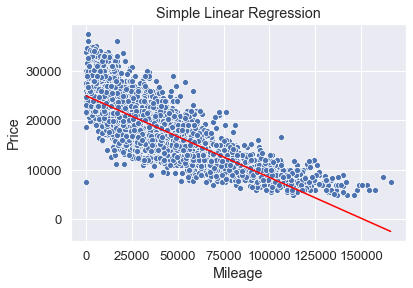

In [685]:
#figure(figsize=(10, 7))
model_pred = model.predict(miles.reshape(-1,1))
sns.scatterplot(df['mileage'], df['price'])
sns.lineplot(miles, model_pred, color = "red")
plt.title("Simple Linear Regression")
plt.xlabel("Mileage")
plt.ylabel("Price")

In [667]:
resids = pd.DataFrame(df['price'] - model_pred)
resids['mileage'] = df['mileage']

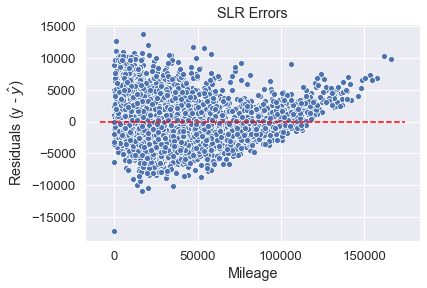

In [693]:
ax = sns.scatterplot(resids['mileage'], resids['price'])
ax.set(title = 'SLR Errors')
ax.set(xlabel = 'Mileage')
ax.set(ylabel = 'Residuals (y - $\hat{y}$)')
abline(0,0)

In [684]:
print('\033[1m', 'Linear Regression:')
print(Style.RESET_ALL)
print('Mean Absolute Error:', '\033[1m', round(metrics.mean_absolute_error(df['price'], model_pred), 2))
print(Style.RESET_ALL)
print('Mean Squared Error:', '\033[1m', round(metrics.mean_squared_error(df['price'], model_pred), 2))
print(Style.RESET_ALL)
print('Root Mean Squared Error:', '\033[1m', round(np.sqrt(metrics.mean_squared_error(df['price'], model_pred)), 2))
print(Style.RESET_ALL)

 Linear Regression:

Mean Absolute Error:  2935.0

Mean Squared Error:  13308710.27

Root Mean Squared Error:  3648.11



#### Polynomial regression:

Text(0, 0.5, 'Price')

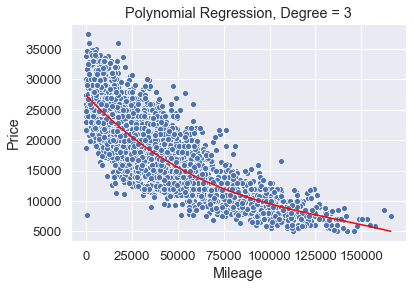

In [694]:
#figure(figsize=(10, 7))
mymodel = np.poly1d(np.polyfit(df['mileage'], df['price'], 3)) # change the degree here
myline = np.linspace(np.min(df['mileage']), np.max(df['mileage']), len(df))
sns.scatterplot(df['mileage'], df['price'])
sns.lineplot(df['mileage'], mymodel(df['mileage']), color = 'red')
plt.title("Polynomial Regression, Degree = 3")
plt.xlabel("Mileage")
plt.ylabel("Price")

In [702]:
print(mymodel(0) - mymodel(25000))
print(mymodel(25000) - mymodel(50000))
print(mymodel(50000) - mymodel(75000))
print(mymodel(75000) - mymodel(100000))

6835.521323381654
4965.312651111764
3507.022248679392
2460.6501160845364


In [672]:
resids2 = pd.DataFrame(df['price'] - mymodel(df['mileage']))
resids2['mileage'] = df['mileage']

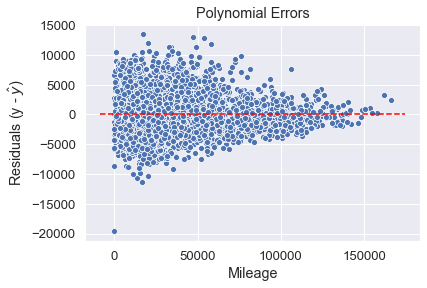

In [695]:
ax = sns.scatterplot(resids2['mileage'], resids2['price'])
ax.set(title = 'Polynomial Errors')
ax.set(xlabel = 'Mileage')
ax.set(ylabel = 'Residuals (y - $\hat{y}$)')
abline(0,0)

In [675]:
print('Polynomial Regression:')
print('Mean Absolute Error:', round(metrics.mean_absolute_error(df['price'], mymodel(df['mileage'])), 2))
print('Mean Squared Error:', round(metrics.mean_squared_error(df['price'], mymodel(df['mileage'])), 2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(df['price'], mymodel(df['mileage']))), 2))

Polynomial Regression:
Mean Absolute Error: 2723.63
Mean Squared Error: 12034739.25
Root Mean Squared Error: 3469.11


In [704]:
np.sqrt(metrics.mean_squared_error(df['price'], model_pred)) / np.sqrt(metrics.mean_squared_error(df['price'], mymodel(df['mileage'])))

1.051597736883719

#### Multiple regression with mileage, year, and price:

y = b1 * x1 + b2 * x2 + b3 * x3 + b4 * x4 + b5 * x5 + b6 * x6

y = price    
1 = mileage   
2 = year   
3 = type (Categorical)  
4 = extColor (Categorical)  
5 = intColor (Categorical)  
6 = transmission (Categorical)  
7 = drivetrain (Categorical)  

Create dummy variables from categorical variables:

In [707]:
df_dummy = pd.concat([pd.DataFrame(df[['mileage', 'year']]),
          pd.get_dummies(data=df['intColor'], prefix = "int"),
          pd.get_dummies(data = df['extColor'], prefix = "ext"),
          pd.get_dummies(data = df['type'], prefix = "type"), # merge the two "type" cols
          pd.get_dummies(data = df['transmission'], prefix = "trans"),
          pd.get_dummies(data = df['drivetrain'], prefix = "dt")], axis = 1)

In [710]:
df_dummy = df_dummy.drop(columns = ['int_Other', 'ext_Other', 'type_Other', 'trans_Manual', 'dt_FWD'])

In [711]:
X = df_dummy.iloc[:, df_dummy.columns != 'price']
Y = df.iloc[:, df.columns == 'price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [712]:
mlr = linear_model.LinearRegression()
mlr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [713]:
coeff_df = pd.DataFrame(mlr.coef_.reshape(-1,1), X_train.columns, columns=['Coefficient'])
coeff_df

,Coefficient
mileage,-0.070398
year,1312.910818
int_Beige,-1531.693370
int_Black,-707.680547
int_Gray,641.760638
ext_Black,-695.562841
ext_Blue,-706.751621
ext_Gray,-295.869480
ext_Silver,-1034.161900
ext_White,-306.115211


In [714]:
y_pred = pd.DataFrame(mlr.predict(X_test)).set_index(Y_test.index)
result = pd.concat([Y_test, y_pred], axis = 1)
result.columns = ['Actual', 'Predicted']
result['Differences'] = result['Actual'] - result['Predicted']
result['Percent_Diff'] = abs((result['Actual'] - result['Predicted']) / result['Actual']) * 100

In [715]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(Y_test, y_pred), 2))
print('Mean Squared Error:', round(metrics.mean_squared_error(Y_test, y_pred), 2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(Y_test, y_pred)), 2))

Mean Absolute Error: 1737.5
Mean Squared Error: 5663889.72
Root Mean Squared Error: 2379.89


In [659]:
Xnew = [[15000, 2018, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]]

In [682]:
pred_price = mlr.predict(Xnew)
print("Predicted Price:", '\033[1m', "$", round(pd.DataFrame(pred_price)[0][0], 2))
print(Style.RESET_ALL)

Predicted Price:  $ 25411.69

